This is run on `chinook`. 

In [ ]:
import itertools
import datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
from scipy.stats import theilslopes

In [ ]:
datadir = Path("../scripts")
fn = "snowacc_12km.nc"
datadir

PosixPath('../scripts')

In [ ]:
with xr.open_dataset(datadir / fn) as src:
    acsnow = src.acsnow
acsnow

<xarray.DataArray 'acsnow' (time: 642, south_north: 204, west_east: 264)> Size: 138MB
[34575552 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
  * time     (time) datetime64[ns] 5kB 1970-01-31 1970-02-28 ... 2023-06-30
Dimensions without coordinates: south_north, west_east

In [ ]:
acsnow.groupby('time.month')[1]

<xarray.DataArray 'acsnow' (time: 54, south_north: 204, west_east: 264)> Size: 12MB
[2908224 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
  * time     (time) datetime64[ns] 432B 1970-01-31 1971-01-31 ... 2023-01-31
Dimensions without coordinates: south_north, west_east

In [ ]:
monthlyclimatology = acsnow.groupby('time.month').mean()

In [ ]:
xr.apply_ufunc(
    lambda x: xr.DataArray(theilslopes(x, np.arange(len(x)))),
    acsnow.groupby('time.month')[1],
    input_core_dims=[["time"]],
    vectorize=True, 
)

<xarray.DataArray 'acsnow' (south_north: 204, west_east: 264)> Size: 431kB
array([[<xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        ...,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ],
       [<xarray.DataArray ()> Size: 8B
...
       [<xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        ...,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ]],
      dtype=object)
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
Dimensions without coordinates: south_north, west_east

In [ ]:
from scipy.stats import theilslopes
monthstheil = {}
for month in range(1, 13):
    monthstheil[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x))),
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        output_core_dims=[['time'], [], [], []],
        vectorize=True, 
    )

ValueError: 0-dimensional argument does not have enough dimensions for all core dimensions ('dim0',)

In [ ]:

monthslower = {}
monthsupper = {}
monthstheilsen = {}
for month in range(1, 13):
    monthstheilsen[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[0],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True, parallel='dask'
    )
    monthslower[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[2],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )
    monthsupper[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[3],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )

In [ ]:
for month in range(1, 13):
    monthstheilsen[month].attrs['units'] = 'kg/m**2'

In [ ]:
monthslower_90 = {}
monthsupper_90 = {}
for month in range(1, 13):
    print(month)
    monthslower_90[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)), alpha=0.9)[2],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )
    monthsupper_90[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)), alpha=0.9)[3],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )

1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
monthsignificant_90 = {}
for month in range(1, 13):
    monthsignificant_90[month] = (
        ((monthstheilsen[month] > 0) & (monthslower_90[month] > 0)) | 
        ((monthstheilsen[month] < 0) & (monthsupper_90[month] < 0))
    )

In [ ]:
monthsignificant = {}
for month in range(1, 13):
    monthsignificant[month] = (
        ((monthstheilsen[month] > 0) & (monthslower[month] > 0)) | 
        ((monthstheilsen[month] < 0) & (monthsupper[month] < 0))
    )

In [ ]:
monthnum = 9
datetime_object = dt.datetime.strptime(str(monthnum), "%m")
month_name = datetime_object.strftime("%b")

/tmp/ipykernel_1235947/3642483683.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend ACSNOW - Sep')

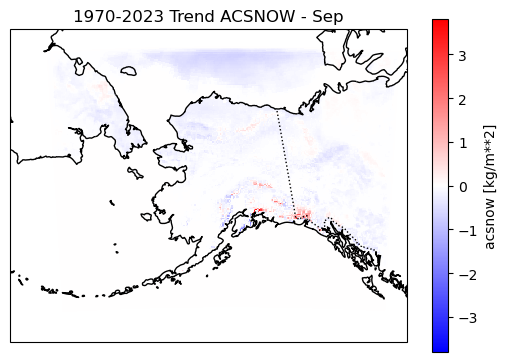

In [ ]:
projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)

ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

monthstheilsen[monthnum].plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",

)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend ACSNOW - {month_name}")

/tmp/ipykernel_1235947/250599052.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend ACSNOW - Sep')

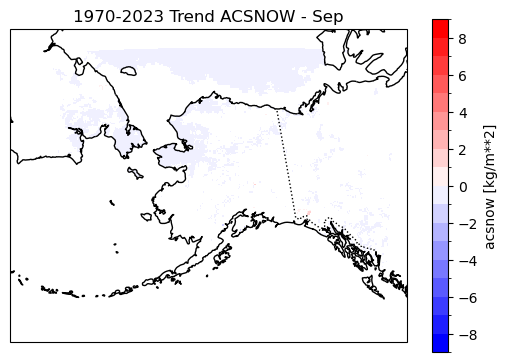

In [ ]:


projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)

# stand_lon=-152.0, moad_cen_lat=63.99999237060547, truelat1=64.0, truelat2=None, pole_lat=90.0, pole_lon=0.0

ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

monthstheilsen[monthnum].where(monthsignificant_90[monthnum]==1).plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",
    levels=19,
    vmax=9
)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend ACSNOW - {month_name}")

In [ ]:
monthlyclimatology.attrs['units'] = 'kg/m**2'

/tmp/ipykernel_1235947/3219357271.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend % ACSNOW - Sep')

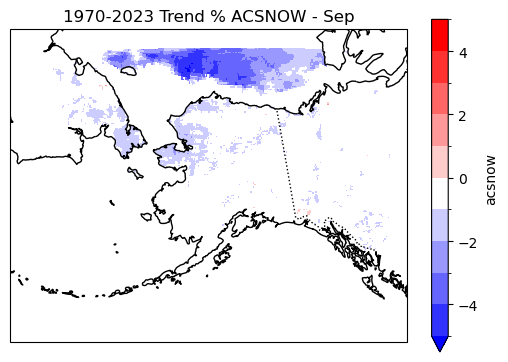

In [ ]:


projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)


ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

(monthstheilsen[monthnum]/monthlyclimatology[monthnum-1] * 100).where(monthsignificant_90[monthnum]==1).plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",
    levels=11,
    vmax=5
)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend % ACSNOW - {month_name}")

In [ ]:
for monthnum in range(1, 13): 
    datetime_object = dt.datetime.strptime(str(monthnum), "%m")
    month_name = datetime_object.strftime("%b")
    monthstheilsen[monthnum].to_netcdf(f"acsnow_theilslope_{month_name}_12km.nc")
    monthlyclimatology[monthnum-1].to_netcdf(f"acsnow_climatology_1970_2023_{month_name}_12km.nc")
    monthsignificant_90[monthnum].to_netcdf(f"acsnow_theilsen_significance_90_{month_name}_12km.nc")
    monthsignificant[monthnum].to_netcdf(f"acsnow_theilsen_significance_95_{month_name}_12km.nc")
    

## First option: Loop through year / month files and aggregate

In [ ]:
%%timeit 
loopyr = testyears_1[:1]
loopmth = months[:2]
time = pd.date_range(testyears_1[0], freq="ME", periods=len(loopyr)*len(loopmth), name='time')

collect = []
for yr in loopyr:
    for mth in loopmth:
        fpths =  sorted(list((datadir / f"{yr}").glob(f"{filepattern_1}_{yr}-{mth}*.nc")))
        acc = [xr.open_dataset(pth).acsnow.sum(dim='Time') for pth in fpths]
        collect.append(sum(acc))

monthly_snowacc_1 = xr.concat(collect, dim=time)
            

15.3 s ± 97.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
loopyr = testyears_1[:1]
loopmth = months[:5]
time = pd.date_range(testyears_1[0], freq="ME", periods=len(loopyr)*len(loopmth), name='time')

collect = []
for yr in loopyr:
    time = pd.date_range(yr, freq="ME", periods=len(loopmth), name='time')
    for mth in loopmth:
        fpths =  sorted(list((datadir / f"{yr}").glob(f"{filepattern_1}_{yr}-{mth}*.nc")))
        acc = [xr.open_dataset(pth, 
                    chunks = {'Time':-1, 'south_north':225, 'west_east':210}).acsnow.sum(dim='Time') for pth in fpths]
        collect.append(sum(acc))

monthly_snowacc_1 = xr.concat(collect, dim=time)

In [ ]:
len(collect)

5

## Second option: use `open_mfdataset` and handle aggregation internally

In [ ]:
filelist_2 = sorted(list(itertools.chain(*[
    list((datadir / f"{yr}").glob("era5_wrf_dscale_4km_*.nc")) for yr in testyears_2])))


In [ ]:
filelist_2

[PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-01.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-02.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-03.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-04.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-05.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-06.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-07.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-08.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-09.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-10.nc'),
 PosixPath('/import/SNAP/cwaigl/wrf_era5/04km/2012/era5_wrf_dscale_4km_2012-01-11.nc'),
 PosixPath('/import/SNAP/cwaigl/

In [ ]:
%%timeit
with xr.open_mfdataset(filelist_2[:152], parallel=True, chunks='auto') as ds:
    snowacc = ds.acsnow

monthly_snowacc_2 = snowacc.resample(Time='ME').sum()


45.1 s ± 850 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
with xr.open_mfdataset(filelist_2[:152], parallel=True, chunks = {'Time':-1, 'south_north':225, 'west_east':210}) as ds:
    snowacc = ds.acsnow

monthly_snowacc_2 = snowacc.resample(Time='ME').sum()

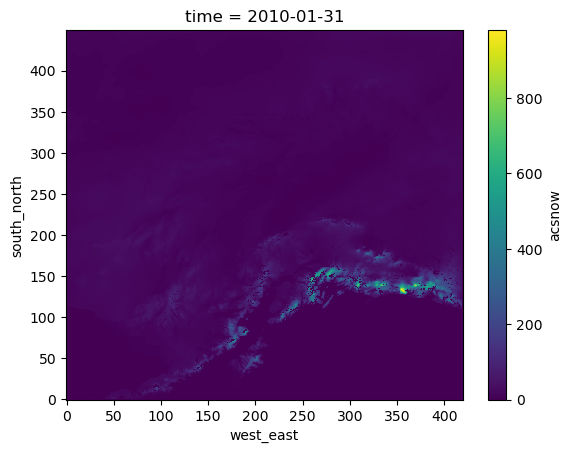

In [ ]:
monthly_snowacc_1.isel(time=0).plot()

In [ ]:
monthly_snowacc_1

<xarray.DataArray 'acsnow' (time: 5, south_north: 450, west_east: 420)> Size: 4MB
dask.array<concatenate, shape=(5, 450, 420), dtype=float32, chunksize=(1, 225, 210), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 756kB -164.9 -164.9 ... -128.6
    XLAT     (south_north, west_east) float32 756kB 55.13 55.14 ... 70.53 70.52
  * time     (time) datetime64[ns] 40B 2010-01-31 2010-02-28 ... 2010-05-31
Dimensions without coordinates: south_north, west_east

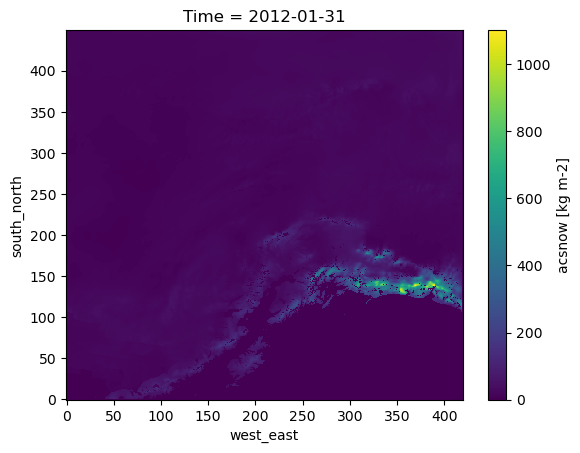

In [ ]:
monthly_snowacc_2.isel(Time=0).plot()

In [ ]:
monthly_snowacc_2

<xarray.DataArray 'acsnow' (Time: 5, south_north: 450, west_east: 420)> Size: 4MB
dask.array<stack, shape=(5, 450, 420), dtype=float32, chunksize=(1, 225, 210), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 756kB dask.array<chunksize=(225, 210), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 756kB dask.array<chunksize=(225, 210), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 40B 2012-01-31 2012-02-29 ... 2012-05-31
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  HOURLY ACCUMULATED SNOW
    units:        kg m-2
    stagger:      
    projection:   PolarStereographic(stand_lon=-152.0, moad_cen_lat=63.999992...

In [ ]:
monthly_snowacc_1.to_netcdf("snowacc1_test.nc", encoding={'acsnow': 
        {"zlib": True, "complevel": 5}})

In [ ]:
with xr.open_dataset(datadir / "2000/era5_wrf_dscale_4km_2000-01-01.nc") as ds:
    snowacc = ds.acsnow
snowacc

KeyboardInterrupt: 